In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import kagglehub

# Download dataset
AUDIO_PATH = kagglehub.dataset_download("unidatapro/american-speech-recognition-dataset")
print("Path to dataset files:", AUDIO_PATH)

100%|██████████| 615k/615k [00:00<00:00, 80.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/unidatapro/american-speech-recognition-dataset/versions/1


In [ ]:
# Constants
MAX_LEN = 40
SAMPLE_RATE = 22050
N_MFCC = 13

# Feature extraction function
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
        if mfcc.shape[0] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, MAX_LEN - mfcc.shape[0]), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:MAX_LEN]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
# Load data
features = []
labels = []
for root, dirs, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            label = os.path.basename(root)
            mfcc = extract_features(file_path)
            features.append(mfcc)
            labels.append(label)



X = np.array(features)
y = np.array(labels)


In [ ]:
# Label encoding
le = LabelEncoder()
y_encoded = tf.keras.utils.to_categorical(le.fit_transform(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Data loaded. Shape: {X.shape}, Classes: {le.classes_}")

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN, N_MFCC)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Data loaded. Shape: (5, 40, 13), Classes: ['audio']
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 1.0000 - loss:

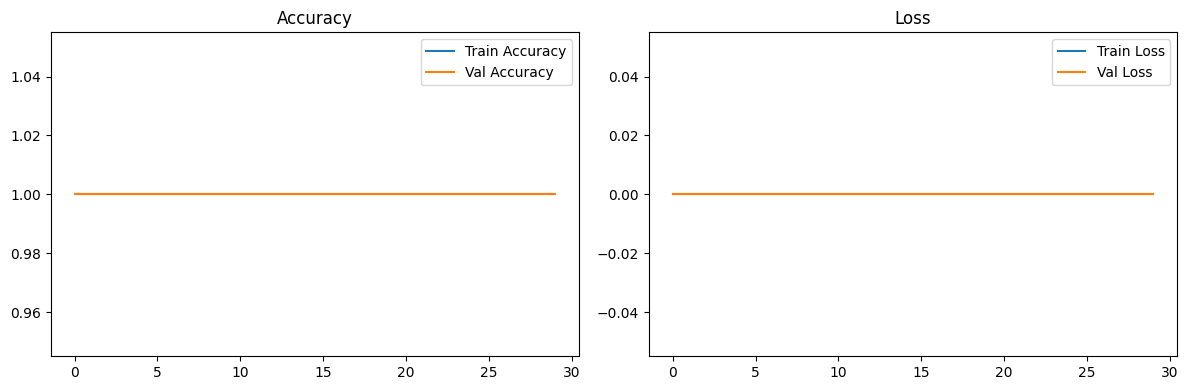

In [ ]:
# Accuracy and loss plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

In [ ]:
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


              precision    recall  f1-score   support

       audio       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


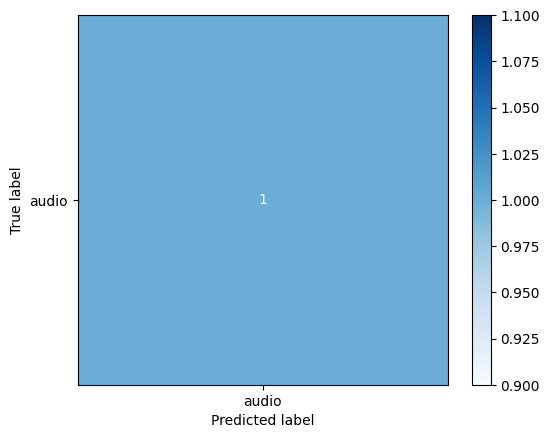

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
!pip install librosa resampy numpy
!pip install librosa resampy numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.4 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from google.colab import files
import os

In [ ]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        if mfccs.shape[1] < 40:
            pad_width = 40 - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :40]
        return mfccs.T
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [ ]:
# Step 5: Prediction function
def predict_gender(audio_file_path):
    mfccs = extract_features(audio_file_path)
    if mfccs is not None:
        mfccs = np.expand_dims(mfccs, axis=0)
        prediction = model.predict(mfccs)
        predicted_class = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_class])[0]
        return predicted_label
    else:
        return "Error extracting features."

In [ ]:
import IPython.display as ipd
uploaded = files.upload()

for fn in uploaded.keys():
    audio_file_path = fn
    predicteds_sound = predict_gender(audio_file_path)
    print(f"Predicted Accident or crime {audio_file_path}: {predicteds_sound}")

    mfccs = extract_features(audio_file_path)

    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs.T, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCCs for {audio_file_path} (Predicted: {predicteds_sound})')
        plt.tight_layout()
        plt.show()

ipd.Audio(audio_file_path)


Saving American Speech Recognition Dataset.csv to American Speech Recognition Dataset (1).csv
Error extracting features from American Speech Recognition Dataset (1).csv: 
Predicted Accident or crime American Speech Recognition Dataset (1).csv: Error extracting features.


<ipython-input-13-5ff8c4848e6d>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-13-5ff8c4848e6d>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error extracting features from American Speech Recognition Dataset (1).csv: 
